## Lade nötige Pakete 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score as sil_score
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture as GM
from copy import copy
import time
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Customized Functions

In [2]:
#   Darstellung der Ziffern, gefunden auf:
#   https://jakevdp.github.io/PythonDataScienceHandbook/
#   05.09-principal-component-analysis.html
def plot_digits(data,m,n):
    fig, axes = plt.subplots(m, n, figsize=(n, m),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0, wspace=0))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))

#------------------------------------------------------------------------------

#   Bilderfolge zur Entwicklung des Patterns 
#   mithilfe einer dazukommenden Hauptkomponente 
def develop_pca(data,index=0,explain_or_ncomp=0.8):
    pca     = PCA(explain_or_ncomp)
    pcadata = pca.fit_transform(data) 
    n       = pca.n_components_

    coeff   = pcadata[index]
    comp    = pca.components_
    mean    = pca.mean_
    test    = copy(mean)
    new     = copy(mean) 
    
    for i in range(n):
        new += coeff[i]*comp[i]
        test = np.vstack((test,new))
        
    fig, axes = plt.subplots(1,n, figsize=(10, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0, wspace=0))
    for i, ax in enumerate(axes.flat):
        ax.imshow(test[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        
#------------------------------------------------------------------------------

def axoptions(axnum,
              xlabel=None,ylabel=None,
              spinesoff=['right','top'],
              xtickoff=False,ytickoff=False,
              title=None):
    '''
    Optionen für einen Plot     
    '''  
    # Achsenbeschriftung setzen
    if xlabel is not None: axnum.set_xlabel(xlabel)
    if ylabel is not None: axnum.set_ylabel(ylabel)
    
    # Frame teilweise entfernen
    try:    
        if len(spinesoff) != 0:    
            [axnum.spines[label].set_visible(False) for label in spinesoff]
    except TypeError: pass

    axnum.tick_params(bottom='off', top='off', right='off', left='off')

    if xtickoff: axnum.set_xticklabels([])
    if ytickoff: axnum.set_yticklabels([])
    
    if title is not None:
        axnum.title.set_text(title)

#------------------------------------------------------------------------------
          
#   Bestimme optimale Clusterzahl mithilfe des Silhouetten-Koeffizienten

def sil(data,k=[5,15]):
    liste = []
    if isinstance(k,int):
        label = KMeans(n_clusters=k).fit_predict(data)
        liste.append([k,sil_score(data,label)])
    else:
        for clus in range(k[0],k[1]+1):
            label = KMeans(n_clusters=clus).fit_predict(data)
            liste.append([clus,sil_score(data,label)])
    liste = np.array(liste)
    return(liste)
    
def optimal_k(data,k=[2,20],n_iter=5,plot=True):     
    kmax = []    
    for i in range(n_iter):     
        liste = sil(data,k)
        kmax.append(int(liste[liste[:,1].argmax(),0]))
    k1     = np.bincount(kmax).argmax()
    if plot:
        max1   = 0
        start = time.time()
        while k1 != max1:
            k1list = sil(data,k)
            max1 = int(k1list[k1list[:,1].argmax(),0])
            if time.time() > start + 120 : break   # Abbruch bei mehr als 2 min
        if k1 == max1:
            plt.plot(k1list[:,0],k1list[:,1],marker='.')
            plt.plot(k1,k1list[k1list[:,0]==k1,1], 'ro')
            plt.title('Silhouettenkoeffizient \nin Abhängigkeit der k=' 
                      + str(k) + '\nmit Maximum bei k=' + str(k1))    
            plt.xlabel('Anzahl an Clustern')
            plt.ylabel('Silhouetten-Koeffizient')   
        else: print('Zeitüberschreitung: Plot konnte nicht erstellt werden')
    print('Silhouetten-Koeffizienten wurden mehrmals(Stabilität) berechnet.\n' +
          'Vorgeschlagene Clusterzahl: k=' + str(k1))
    return(k1)
           

#------------------------------------------------------------------------------

def color(val1,val2):
    if val1 != val2: return('background-color: red')
    
#------------------------------------------------------------------------------
    
def nearest(array,number): 
    return(array.flat[np.abs(array - number).argmin()])     
    
#------------------------------------------------------------------------------

def evaluate_logistic(model,xtest,ytest):

    ypredict        = model.predict(xtest) # Sage die Klasse der Testdaten voraus
    ypredictprob    = model.predict_proba(xtest) 
    ypredictprobmax = np.amax(ypredictprob,axis=1)
    yoverview       = np.vstack((ytest,ypredict,ypredictprobmax)).T
    ysameprob       = yoverview[yoverview[:,0] == yoverview[:,1],2]
    n               = len(ysameprob)
    xyquan          = np.vstack((np.quantile(ysameprob,np.arange(0,1,1/n)),
                                np.arange(0,1,1/n))).T


    text1 = '\n######## EVALUATION LOGISTISCHES MODELL ########' \
            + '\n\nAnteil korrekter Vorhersagen zu allen Vorhersagen (Genauigkeit)' \
            + '\nrelativ: '
    text2 = '\nabsolut: '
    text31= '\n\nAb hier nur noch Betrachtung aller '
    text32= ' W\'keiten \nder korrekten Vorhersagen (Diagonalen)'
    text4 = '\nSpanne: '
    text5 = '\nQuantile: 1%\t5%\t10%\t20%\t50%'
    text6 = '\nMittelwert der W\'keiten: '  
    
    acc   = model.score(xtest,ytest) # gemittelte Genauigkeit der Vorhersagen der Testdaten
    absol = str(int(180 *acc)) + '/180'
    mittel= str('{:3.1f}'.format(np.mean(ysameprob)*100)) + ' %'
    quan  = np.quantile(ysameprob,[0.01,0.05,0.1,0.2,0.5])*100
    span = str(int(min(ysameprob)*100)) + ' % - '+ str(int(np.ceil(max(ysameprob)*100))) + ' %'
    
    print(text1 + str('{:3.1f}'.format(acc*100)) + ' %' 
          + text2 + absol)
    
    cm = pd.DataFrame(confusion_matrix(ytest,ypredict),range(10),range(10))
    plt.figure(figsize = (8,5))
    sns.set(font_scale=1.2)
    ax=sns.heatmap(cm, annot=True,annot_kws={"size": 14},cmap="Blues")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.show(ax)

    print(text31 + str(n) + text32)
    
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,4))
    ax1.plot(xyquan[:,0],xyquan[:,1])
    ax2.plot(xyquan[:,0],xyquan[:,1])
    ax2.set_xlim([0.9, 1])
    ax1.set_xlabel('Quantil (Vorhersagewahrscheinlichkeit)')
    ax2.set_xlabel('Quantil (Vorhersagewahrscheinlichkeit)')
    ax1.set_ylabel('Anteil in %')    
    rec = Rectangle((0.9,0),0.1,1,linewidth=1,edgecolor='g',facecolor='none')
    ax1.add_patch(rec)
    ax2.spines['right'].set_color('g'),ax2.spines['bottom'].set_color('g')
    ax2.spines['left'].set_color('g'),ax2.spines['top'].set_color('g')
    ax1.plot(0.95,0.2, marker='o', markersize=7, color='r')
    ax2.axvline(x=xyquan[xyquan[:,1]==0.5,0],color='grey',linewidth=0.5,ymax=0.5)
    ax2.text(0.977,0.5,'Median')
    ax2.axvline(x=nearest(xyquan[:,0],0.956),
                color='grey',linewidth=0.5,
                ymax=0.23)
    ax2.text(0.94,0.27,'Mittelwert')
    plt.show()
    
    print(text4 + span
          + text5 
          + '\n\t  ' + str(int(quan[0]))
          + '\t' + str(int(quan[1]))
          + '\t' + str(int(quan[2]))
          + '\t' + str(int(quan[3]))
          + '\t' + str('{:3.1f}'.format(quan[4]))
          + text6 + mittel)

## Daten laden
Lade den Datensatz *Digits*.
Zeige die ersten 30 Patterns ($8 x 8$ Matrizen) mithilfe der Funktion `plot_digits`.
Erstelle für die Klassifikationsmodelle bereits Trainings- und Testsätze:

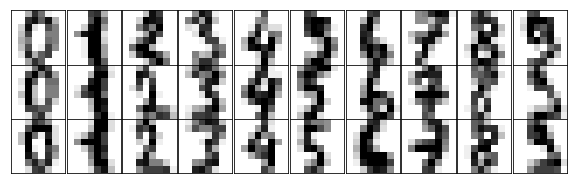

In [3]:
df   = datasets.load_digits()
data = df['data']
plot_digits(data,3,10)

In [4]:
xtrain,xtest,ytrain,ytest = tts(data,df.target,test_size=0.1,random_state=0)

print('Dimensionen des Datensatzes: \t'
+ str(data.shape) +
'\nDimensionen des Trainingssatzes:' + str(xtrain.shape) +
'\nDimensionen des Testsatzes:\t'
+ str(xtest.shape))

Dimensionen des Datensatzes: 	(1797, 64)
Dimensionen des Trainingssatzes:(1617, 64)
Dimensionen des Testsatzes:	(180, 64)


## Datenreduktion mithilfe der klassischen PCA
Statt mit dem Originaldatensatz zu arbeiten, ist es möglich, unter Varianzverlust Daten reduziert
wiederzugeben. In diesem Fall beträgt der Verlust 20%, da ich mich zu 80% erklärter Varianz
entschieden habe. So kommen statt 64 Komponenten am Ende 13 heraus, die das Original trotzdem gut repräsentieren.  

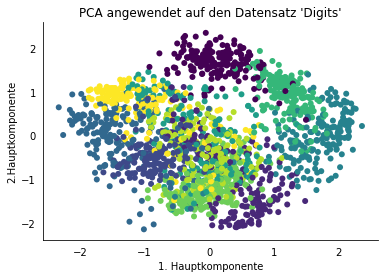

In [5]:
pca     = PCA(0.80)
pcadata = pca.fit_transform(data) # projizierte 1797 x 13 Matrix
#n = pca.n_components_

scaler  = StandardScaler()
pcadata = scaler.fit_transform(pcadata)

x       = pcadata[:,0]
y       = pcadata[:,1]

fig,ax  = plt.subplots(figsize=(6,4))
ax.scatter(x,y,c=df['target'],edgecolor='none')
axoptions(ax,xlabel='1. Hauptkomponente',
          ylabel='2.Hauptkomponente',
          title= "PCA angewendet auf den Datensatz 'Digits'")

Nun wurde die PCA auf den Datensatz angewandt und die erste Hauptkomponente(HK)
gegen die zweite geplottet.  
Die unterschiedlichen Farben sind den unterschiedlichen Labeln, also in diesem Fall den Ziffern, zuzuordnen.  
Als nächstes kann man sehen, wie die HK zum Tragen kommen. Mit ihnen als Basis und einer Mittelwertmatrix kann das Bild nach und nach verbessert werden:

[None, None, None, None]

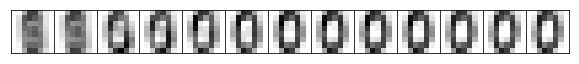

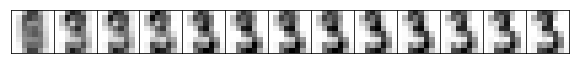

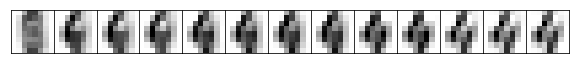

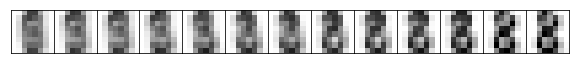

In [6]:
[develop_pca(data,i) for i in [0,3,4,8]]

Mögliche robuste Alternativen aus dem Paket `sklearn` wären *SparsePCA* und *RandomizedPCA*. SparsePCA arbeitet mit Sparseness in seinen Matrizen, das heißt, schrauben wir sie zum
Beispiel hoch, werden viel mehr Nullen in der Matrix produziert. So kann das Ergebnis aufgrund
seiner Überschaubarkeit leichter interpretiert werden.  

# Cluster
## Kmeans
Der Fokus in diesem Kapitel liegt auf den drei Clusteralgorithmen *Kmeans*, *DBScan* und *GaussianMixture*, alle aus dem Paket `sklearn`. Wesentlich ist hier für mich auch, auf die mögliche Automatisierung der optimalen Parameter einzugehen. Weiterhin nehmen wir beim Clustern immer an, dass wir keinerlei Information zum Datensatz haben und lassen die Algorithmen deshalb *unsupervised* lernen.

Um nun die optimale Zahl $k$ an Clustern zu erhalten, kann die Funktion `optimal_k` auf dem reduzierten Datensatz gestartet werden. Jedoch habe ich sie direkt auskommentiert, da sie sehr langsam ist und direkt unser $k_1=9$ gesetzt.  

In [7]:
#k1 = optimal_k(pcadata)
k1 = 9
#k2 = optimal_k(data)
#if k1 == k2: del k2

Nun wird KMeans auf *pcadata* mit $k_1=9$ und $k=10$ angewandt und die Labels als Farben für den abschließenden Plot genutzt.

In [8]:
labkmean1  = KMeans(n_clusters=k1).fit_predict(pcadata)
labkmean2  = KMeans(n_clusters=10).fit_predict(pcadata)

## DBScan
Dieser Algorithmus schien für mich sehr interessant, da er sehr intuitiv mit den Inputvariablen *min_samples* (minimale Zahl an Punkten pro Cluster) und *eps* (Abstand zwischen zwei Punkten) Density Based arbeitet und sich auch geschickt um Ausreißer kümmert.

In [9]:
db        = DBSCAN(min_samples=14,eps=2.2)
db.fit(pcadata)
coldb     = db.fit_predict(pcadata)

size      = copy(coldb)
size[size != -1] = 20
size[size == -1] = 5

## GaussianMixture
Dieser Algorithmus erschien nach der Form des Datensatzes passend. Daneben existieren auch der BayesianGaussianMixture-, Naive-Bayes- und weitere Algorithmen. Mithilfe der Akaike-(aic) und Bayesian-Information(bic) kann die optimale Zahl an Komponenten geschätzt werden.

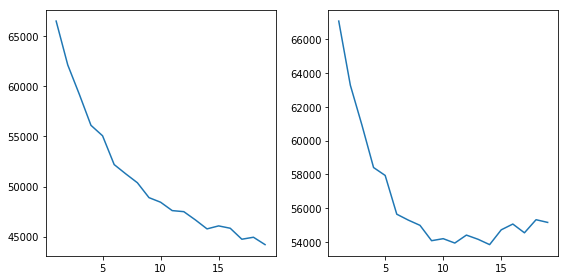

In [10]:
ncomp        = np.arange(1,20)
gmodel       = [GM(n) for n in ncomp]
fitted       = [model.fit(pcadata) for model in gmodel]
aics         = [fit.aic(pcadata) for fit in fitted]
bics         = [fit.bic(pcadata) for fit in fitted]

plt.figure(figsize=(8,4))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
ax1.plot(ncomp, aics)
ax2.plot(ncomp, bics)
plt.tight_layout()

Dort, wo sich ein Minimum ergibt, kann die Zahl abgelesen werden.   
Wir wählen #Komp $=10$, auch wenn es hier nicht ganz eindeutig ist.

In [11]:
gauss = GM(10)
colg  = gauss.fit_predict(pcadata)

## Überblick über alle Clustermethoden

Text(0.5, 0.98, "Zusammenfassung aller angewandten Clustermethoden auf den Datensatz 'Digits'")

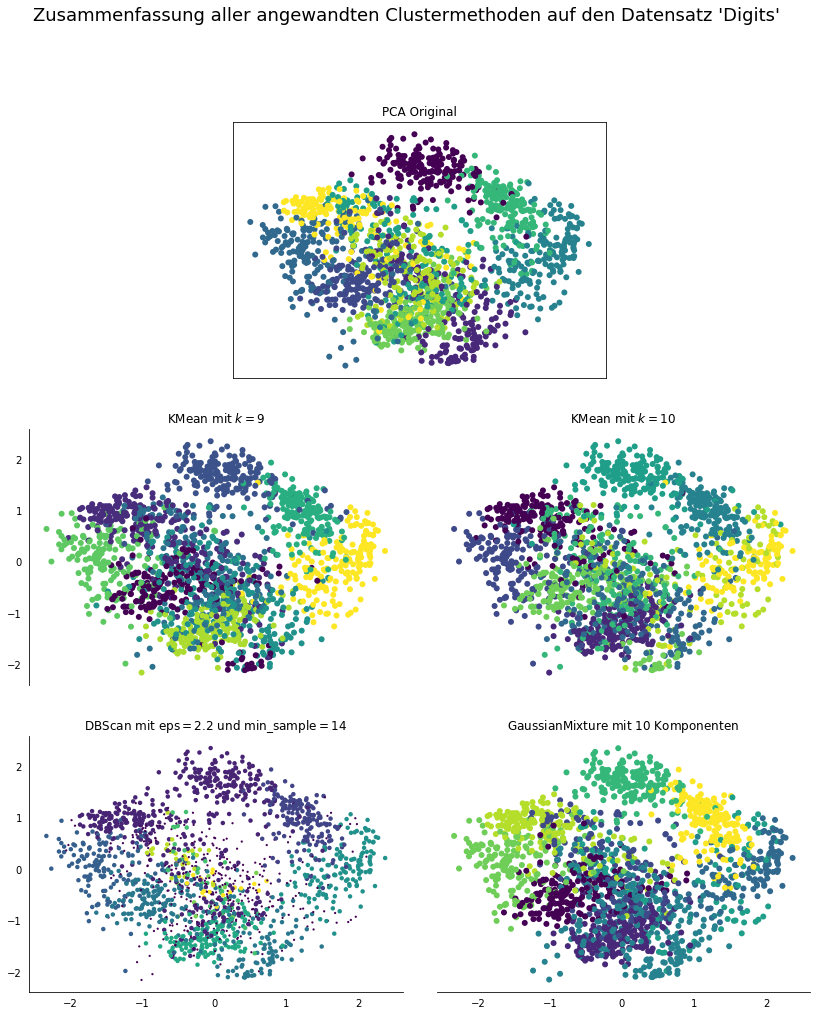

In [12]:
plt.figure(figsize=(14,16))

ax1 = plt.subplot2grid((3,4), (0, 1),colspan=2)
ax2 = plt.subplot2grid((3,4), (1, 0),colspan=2)
ax3 = plt.subplot2grid((3,4), (1, 2),colspan=2)
ax4 = plt.subplot2grid((3,4), (2, 0),colspan=2)
ax5 = plt.subplot2grid((3,4), (2, 2),colspan=2)

ax1.scatter(x,y,c=df['target'],edgecolor='none')
ax2.scatter(x,y,c=labkmean1,edgecolor='none')
ax3.scatter(x,y,c=labkmean2,edgecolor='none')
ax4.scatter(x,y,c=coldb,edgecolor='none',s=size)
ax5.scatter(x,y,c=colg,edgecolor='none')

axes = [ax2,ax3,ax4,ax5]

axoptions(ax1,spinesoff=[],xtickoff=True,ytickoff=True,title='PCA Original')
[axoptions(ax) for ax in axes]
[axoptions(ax,xtickoff=True,spinesoff=['top','right','bottom']) for ax in [ax2,ax3]]
[axoptions(ax,ytickoff=True,spinesoff=['top','right','left']) for ax in [ax3,ax5]]

ax2.title.set_text('KMean mit $k=9$')
ax3.title.set_text('KMean mit $k=10$')
ax4.title.set_text('DBScan mit eps$=2.2$ und min_sample$=14$')
ax5.title.set_text('GaussianMixture mit $10$ Komponenten')

plt.suptitle(("Zusammenfassung aller angewandten Clustermethoden " + 
             "auf den Datensatz 'Digits'"),fontsize=18)

# Klassifikation: logistische Regression
Eine lineare Regression sagt uns direkt etwas zu einer Variablen voraus. Der Unterschied bei einer logistischen ist die Voraussage der **Wahrscheinlichkeit** eines Ereigniseintritts. Somit gilt immer $f(x) \in [0,1]$ für die Sigmoid-Funktion $f$.  
Weiterhin kann eine logistische Regression nur binäre Entscheidungen (zB. $1 = $'ja' oder $0 = $'nein') treffen. $0.5$ fungiert hier als Schwellenwert. Liegt der Wert drunter, entscheidet man sich für 'nein', da drüber dann für 'ja'.   
Eine multilogistische Regression kann durch das One-vs-All-Verfahren und die Softmax-Funktion durchgeführt werden. Dazu wird für $n$ Klassen jeweils die relevante Klasse gegenüber allen zusammen gesetzt und somit eine logistische Regression $n$-mal durchgeführt.  

Nun wird der am Anfang erstellte Trainingsdatensatz *xtrain* mit seinen Labels *ytrain* in das Modell eingebettet. 

In [13]:
model       = LogisticRegression()
model.fit(xtrain,ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Evaluation

Mithilfe der Funktion `evaluate_logistic` können wir oben trainiertes Modell bewerten und uns Kennziffern ausgeben lassen:


######## EVALUATION LOGISTISCHES MODELL ########

Anteil korrekter Vorhersagen zu allen Vorhersagen (Genauigkeit)
relativ: 95.6 %
absolut: 172/180


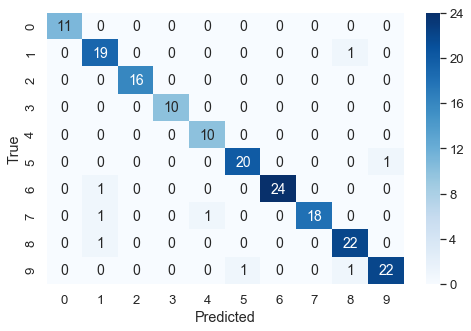



Ab hier nur noch Betrachtung aller 172 W'keiten 
der korrekten Vorhersagen (Diagonalen)


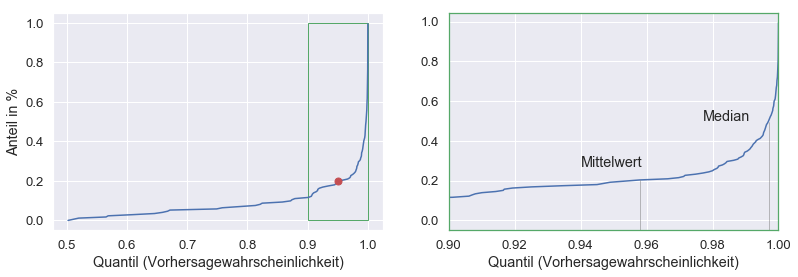


Spanne: 50 % - 100 %
Quantile: 1%	5%	10%	20%	50%
	  51	66	87	95	99.7
Mittelwert der W'keiten: 95.6 %


In [14]:
evaluate_logistic(model,xtest,ytest)

In der Confusion-Matrix, oder auch Heatmap genannt, können wir sehen, wieviele Werte wie vorhergesagt wurden. Auf den Diagonalen ist die Anzahl der korrekt vorhergesagten Werte zu sehen. $8$ Werte hingegen liegen nicht auf der Diagonalen und wurden falsch vorhergesagt. Beispielsweise sagt uns die $1$ oben rechts, dass einmal statt der $1$ (y-Achse) die $8$ (x-Achse) vorhergesagt wurde. Auffällig ist im unteren Dreieck das Phänomen, in welchem häufig die wahren Werte fälschlicherweise als $1$ interpretiert werden.  

Bei der Betrachtung der $172$ korrekten Werte schauen wir uns die Vorhersagewahrscheinlichkeit(Vowa) an. Die Spanne sagt uns, dass die geringste Vowa bei $50\%$ und die höchste bei $100\%$, was aber $99.999999....\%$ meint. Eine geringere Vowa gibt es bei den korrekten Aussagen also nicht. In den Plots sehen wir die kumulierten Anteile der Vowa in Abhängigkeit ihrer Quantile zB. bedeutet der rote Punkt: $80\%$ der Daten haben eine Vowa größer $95\%$. Das ist sehr gut! Zoomen wir in den Plot, speziell den Bereich der hohen Vowa (grünes Fenster) hinein, sehen wir, dass der Mittelwert etwas unter dem Median bei $95.6\%$ liegt. Der Median liegt, obwohl so weit hineingezoomt, sehr weit rechts, was aber ein gutes Zeichen ist, da damit die Hälfte der Daten mit mindestens $99.7\%$ Wahrscheinlichkeit vorhergesagt werden.  

Schauen wir uns die $8$ falsch vorhergesagten Werte an:

In [15]:
ypredict    = model.predict(xtest) 

print('Vorhersage: ' + str(ypredict[ytest != ypredict]) + '\nWahr:\t    ' + str(ytest[ytest != ypredict])) 


Vorhersage: [8 9 4 1 1 1 5 8]
Wahr:	    [1 5 7 7 6 8 9 9]


Die erste Zeile ist die Vorhersage, die zweite die richtigen Werte der Handschrift.

Meist gibt es eine Verwechslung zwischen der 5 und der 9. Durch das Bild unten ist dies auch nachvollziehbar. Dort sehen wir zuerst eine handgeschriebene $5$, dann eine $9$.  

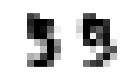

In [16]:
plot_digits(data[[5,9]],1,2)

Oft kommt bei den falschen Werten, wie bereits genannt, die $1$ sehr häufig vor. Die $2$ und $3$ hingegen sind bei den Werten in keinster Weise involviert. 

## Weiteres Beispiel: Einfaches Koordinatensystem
Ein weiteres, selbst konstruiertes Beispiel sind zufällig angeordnete Datenpunkte (blau) und Testpunkte (rot).  

Mithilfe von DBScan erhalten die Datenpunkte zunächst einmal ihre Labels. Diese werden danach in das logistische Modell eingefüttert.

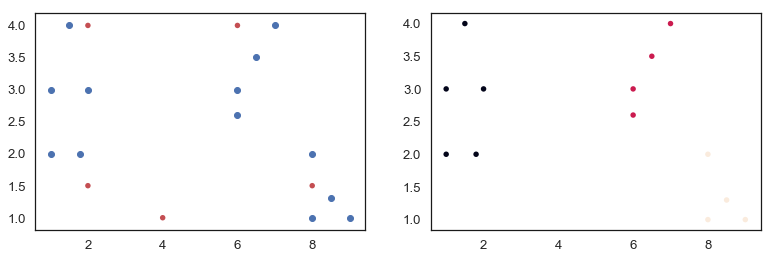

In [17]:
points=np.array(((1,2),(1.5,4),(6,3),(1.8,2),(9,1),
                 (2,3),(1,3),(6,2.6),(8,1),(8,2),(7,4),
                 (6.5,3.5),(8.5,1.3)))
testpoints=np.array(((2,1.5),(2,4),(6,4),(4,1),(8,1.5)))

db1          = DBSCAN(min_samples=4,eps=2)
db1.fit(points)
coldb1       = db1.fit_predict(points)

plt.figure(figsize=(13,4))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
direc = ['top','bottom','left','right']
for ax in [ax1,ax2]:
    ax.set_facecolor('w')
    [ax.spines[d].set_color('k') for d in direc] 
ax1.scatter(points[:,0],points[:,1])
ax1.scatter(testpoints[:,0],testpoints[:,1],c='r',s=30,edgecolor='none')
ax2.scatter(points[:,0],points[:,1],c=coldb1,edgecolor='none',s=30)
plt.show()

In [18]:
mod = LogisticRegression()
mod.fit(points,coldb1)
testpointspredict = mod.predict(testpoints)

Nun haben auch die Testpunkte ihrer Labels und das Ergebnis kann geplottet werden:

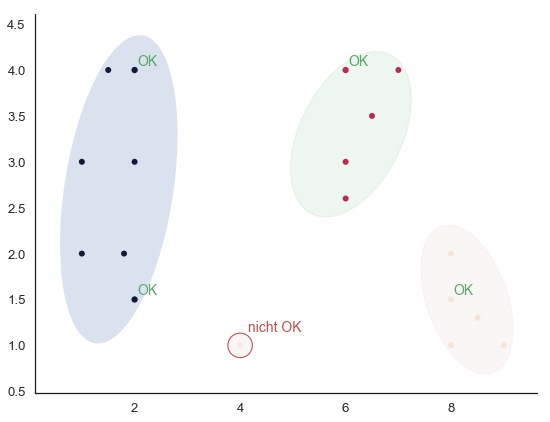

In [19]:
plt.figure(figsize=(9,7))
ax = plt.subplot2grid((1, 1), (0, 0)) 
ax.set_facecolor('w')
[ax.spines[d].set_color('k') for d in ['bottom','left']]
ax.scatter(4,1,c='brown',edgecolor='none',s=600,alpha=0.04)
ax.scatter(4,1,c='none',edgecolor='r',s=600,linewidth=1.1)
ax.add_patch(Ellipse((1.7,2.7),3.5,2, 70, alpha=0.2,edgecolor='none'))
ax.add_patch(Ellipse((6.1,3.3),2.5,1.5,30,alpha=0.1,edgecolor='none',color='g'))
ax.add_patch(Ellipse((8.3,1.5),2,1.3,140, alpha=0.04,edgecolor='none',color='brown'))
ax.text(4.15,1.15,'nicht OK',color='r',fontsize=14)
ax.scatter(points[:,0],points[:,1],c=coldb1,edgecolor='none')
ax.scatter(testpoints[:,0],testpoints[:,1],c=testpointspredict,
            edgecolor='none',s=40)
cenx = [2.05,2.05,6.05,8.05]
ceny = [1.55,4.05,4.05,1.55]
[ax.text(i,j,'OK',color='g',fontsize=14) for i,j in zip(cenx,ceny)]
plt.show()

Vier Punkte wurden auch mit der menschlichen Intuition übereinstimmend korrekt eingeordnet. Der 5. Punkt, augenscheinlich ein Ausreißer, musste der Klassifikation nach trotzdem irgendwo einsortiert werden. Da das Clusterzentrum unten rechts am nahsten an dem Punkt liegt, wurde er diesem Cluster zugeordnet.    